**Projet 8: Traiter les images pour le syst√®me embarqu√© d‚Äôune voiture autonome** 

Dans ce notebook, nous allons tester diff√©rents mod√®les pour r√©aliser une segmentation en 8 cat√©gories des images pour le syst√®me embarqu√© d'une voiture autonome;
Nous commencerons par des mod√®les "basiques", qui seront notre baseline de r√©f√©rence vs des modeles plus √©labor√©s de deep learning.
Dans l'orde nous allons tester:
* 

Tous les modeles sont stock√©s en centralis√© sur MLflow (local).
Le mod√®le le plus performant (avec la meilleure accuracy) sera utilis√© pour le d√©ploiement en production sur le cloud via un API de prediction.
Derriere, nous developperons √©galement un pipeline CI/CD qui nous aidera √† d√©ployer le dernier modele automatiquement sur le cloud sur simple PUSH via Git Hub Actions;

> "View" > "Table of contents" pour voir le plan du notebook

# 1. Imports et param√©trages

## 1.1 Installation des librairies

In [1]:
!pip install pandas numpy matplotlib scikit-learn missingno mlflow tf-keras tqdm albumentations tf-keras==2.16.0

In [2]:
# !pip install pandas numpy seaborn matplotlib scikit-learn missingno nltk 
# !pip install gensim transformers tensorflow-cpu==2.16.1 tf-keras==2.16.0 tensorflow_hub plot-keras-history
# !pip install opencv-python-headless opencv-contrib-python 

## 1.2 Import des Librairies

In [3]:
# 1. Manipulation de donn√©es et calculs num√©riques :
import numpy as np
import pandas as pd
import math
import multiprocessing

# 2. Gestion de fichiers et chemins :
import os
from pathlib import Path
import pickle

# 3. Visualisation :
import matplotlib.pyplot as plt
import tqdm

# 4. Traitement d'images et augmentations :
import cv2
from tensorflow.keras.preprocessing import image
import albumentations as A

# 5. TensorFlow et Keras (mod√®les, couches, optimisations, pertes, callbacks) :
import tensorflow as tf
from tensorflow.keras import layers, models, applications, optimizers, losses, callbacks, backend as K
from tensorflow.keras.layers import Input
from tensorflow.keras.models import load_model
from tensorflow.keras.applications import VGG16
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping, Callback
from keras.saving import register_keras_serializable

# 6. MLflow (suivi d'exp√©riences et centralisation des mod√®les) :
import mlflow

In [4]:
! pip freeze

absl-py==2.1.0
albucore==0.0.23
albumentations==2.0.5
alembic==1.14.1
annotated-types==0.7.0
anyio==4.8.0
argon2-cffi==23.1.0
argon2-cffi-bindings==21.2.0
arrow==1.3.0
asttokens==3.0.0
astunparse==1.6.3
async-lru==2.0.4
attrs==25.1.0
babel==2.17.0
beautifulsoup4==4.13.3
bleach==6.2.0
blinker==1.9.0
cachetools==5.5.2
certifi==2025.1.31
cffi==1.17.1
charset-normalizer==3.4.1
click==8.1.8
cloudpickle==3.1.1
colorama==0.4.6
comm==0.2.2
contourpy==1.3.1
cycler==0.12.1
databricks-sdk==0.44.1
debugpy==1.8.12
decorator==5.2.1
defusedxml==0.7.1
Deprecated==1.2.18
docker==7.1.0
executing==2.2.0
fastapi==0.115.11
fastjsonschema==2.21.1
Flask==3.1.0
flatbuffers==25.2.10
fonttools==4.56.0
fqdn==1.5.1
gast==0.6.0
gitdb==4.0.12
GitPython==3.1.44
google-auth==2.38.0
google-pasta==0.2.0
graphene==3.4.3
graphql-core==3.2.6
graphql-relay==3.2.0
greenlet==3.1.1
grpcio==1.70.0
h11==0.14.0
h5py==3.13.0
httpcore==1.0.7
httpx==0.28.1
idna==3.10
importlib_metadata==8.5.0
ipykernel==6.29.5
ipython==9.0.0
ipytho

## 1.3 Param√©trages

In [5]:
#parametrage de panda pour afficher toutes les colonnes sans les tronquer
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)


In [6]:
# Configuration MLflow
mlflow.set_tracking_uri("http://127.0.0.1:5000")
mlflow.set_experiment("segmentation_images")

<Experiment: artifact_location='mlflow-artifacts:/615947391303416845', creation_time=1741172112987, experiment_id='615947391303416845', last_update_time=1741172112987, lifecycle_stage='active', name='segmentation_images', tags={}>

## 1.4 Fonctions

### 1.4.1 Obtention des chemins pour images et masques

In [7]:
# Extensions valides pour les images
IMAGE_MASK_EXTENSIONS = {".png", ".jpg", ".jpeg", ".npy"}

In [8]:

def get_image_paths(root_dir):
    """
    R√©cup√®re les chemins des images en parcourant r√©cursivement les dossiers.
    Trie les chemins en fonction de leur emplacement relatif pour assurer l'alignement entre images et masques.
    Ignore les images du dossier 'test/' car leurs masques relatifs ne sont pas fournis par Cityscape.
    """
    paths = [
        p for p in Path(root_dir).rglob("*") 
        if p.suffix.lower() in IMAGE_MASK_EXTENSIONS
        and ("train" in str(p) or "val" in str(p))  # Ignore "test/"
    ]
    return sorted(paths, key=lambda p: p.relative_to(root_dir))


In [9]:
def get_mask_paths(root_dir, mask_type="_gtFine_labelIds"):
    """
    R√©cup√®re les chemins des masques en filtrant ceux contenant un type sp√©cifique.
    Utilise les masques de segmentation s√©mantique (_gtFine_labelIds).
    Ignore les masques du dossier 'test/' car ils ne sont pas fournis.
    """
    paths = [
        p for p in Path(root_dir).rglob("*")
        if p.suffix.lower() in IMAGE_MASK_EXTENSIONS 
        and mask_type in p.stem 
        and ("train" in str(p) or "val" in str(p))  # Ignore "test/"
    ]
    return sorted(paths, key=lambda p: p.relative_to(root_dir))


### 1.4.2 Simplification des cat√©gories

code pour visualiser les diff√©rentes categs de cityscapes. 
Ce code provient directement du github de cityscapes: 
https://github.com/mcordts/cityscapesScripts/blob/master/cityscapesscripts/helpers/labels.py

In [10]:
from collections import namedtuple

In [11]:
#--------------------------------------------------------------------------------
# Definitions
#--------------------------------------------------------------------------------

# a label and all meta information
Label = namedtuple( 'Label' , [

    'name'        , # The identifier of this label, e.g. 'car', 'person', ... .
                    # We use them to uniquely name a class

    'id'          , # An integer ID that is associated with this label.
                    # The IDs are used to represent the label in ground truth images
                    # An ID of -1 means that this label does not have an ID and thus
                    # is ignored when creating ground truth images (e.g. license plate).
                    # Do not modify these IDs, since exactly these IDs are expected by the
                    # evaluation server.

    'trainId'     , # Feel free to modify these IDs as suitable for your method. Then create
                    # ground truth images with train IDs, using the tools provided in the
                    # 'preparation' folder. However, make sure to validate or submit results
                    # to our evaluation server using the regular IDs above!
                    # For trainIds, multiple labels might have the same ID. Then, these labels
                    # are mapped to the same class in the ground truth images. For the inverse
                    # mapping, we use the label that is defined first in the list below.
                    # For example, mapping all void-type classes to the same ID in training,
                    # might make sense for some approaches.
                    # Max value is 255!

    'category'    , # The name of the category that this label belongs to

    'categoryId'  , # The ID of this category. Used to create ground truth images
                    # on category level.

    'hasInstances', # Whether this label distinguishes between single instances or not

    'ignoreInEval', # Whether pixels having this class as ground truth label are ignored
                    # during evaluations or not

    'color'       , # The color of this label
    ] )

labels = [
    #       name                     id    trainId   category            catId     hasInstances   ignoreInEval   color
    Label(  'unlabeled'            ,  0 ,      255 , 'void'            , 0       , False        , True         , (  0,  0,  0) ),
    Label(  'ego vehicle'          ,  1 ,      255 , 'void'            , 0       , False        , True         , (  0,  0,  0) ),
    Label(  'rectification border' ,  2 ,      255 , 'void'            , 0       , False        , True         , (  0,  0,  0) ),
    Label(  'out of roi'           ,  3 ,      255 , 'void'            , 0       , False        , True         , (  0,  0,  0) ),
    Label(  'static'               ,  4 ,      255 , 'void'            , 0       , False        , True         , (  0,  0,  0) ),
    Label(  'dynamic'              ,  5 ,      255 , 'void'            , 0       , False        , True         , (111, 74,  0) ),
    Label(  'ground'               ,  6 ,      255 , 'void'            , 0       , False        , True         , ( 81,  0, 81) ),
    Label(  'road'                 ,  7 ,        0 , 'flat'            , 1       , False        , False        , (128, 64,128) ),
    Label(  'sidewalk'             ,  8 ,        1 , 'flat'            , 1       , False        , False        , (244, 35,232) ),
    Label(  'parking'              ,  9 ,      255 , 'flat'            , 1       , False        , True         , (250,170,160) ),
    Label(  'rail track'           , 10 ,      255 , 'flat'            , 1       , False        , True         , (230,150,140) ),
    Label(  'building'             , 11 ,        2 , 'construction'    , 2       , False        , False        , ( 70, 70, 70) ),
    Label(  'wall'                 , 12 ,        3 , 'construction'    , 2       , False        , False        , (102,102,156) ),
    Label(  'fence'                , 13 ,        4 , 'construction'    , 2       , False        , False        , (190,153,153) ),
    Label(  'guard rail'           , 14 ,      255 , 'construction'    , 2       , False        , True         , (180,165,180) ),
    Label(  'bridge'               , 15 ,      255 , 'construction'    , 2       , False        , True         , (150,100,100) ),
    Label(  'tunnel'               , 16 ,      255 , 'construction'    , 2       , False        , True         , (150,120, 90) ),
    Label(  'pole'                 , 17 ,        5 , 'object'          , 3       , False        , False        , (153,153,153) ),
    Label(  'polegroup'            , 18 ,      255 , 'object'          , 3       , False        , True         , (153,153,153) ),
    Label(  'traffic light'        , 19 ,        6 , 'object'          , 3       , False        , False        , (250,170, 30) ),
    Label(  'traffic sign'         , 20 ,        7 , 'object'          , 3       , False        , False        , (220,220,  0) ),
    Label(  'vegetation'           , 21 ,        8 , 'nature'          , 4       , False        , False        , (107,142, 35) ),
    Label(  'terrain'              , 22 ,        9 , 'nature'          , 4       , False        , False        , (152,251,152) ),
    Label(  'sky'                  , 23 ,       10 , 'sky'             , 5       , False        , False        , ( 70,130,180) ),
    Label(  'person'               , 24 ,       11 , 'human'           , 6       , True         , False        , (220, 20, 60) ),
    Label(  'rider'                , 25 ,       12 , 'human'           , 6       , True         , False        , (255,  0,  0) ),
    Label(  'car'                  , 26 ,       13 , 'vehicle'         , 7       , True         , False        , (  0,  0,142) ),
    Label(  'truck'                , 27 ,       14 , 'vehicle'         , 7       , True         , False        , (  0,  0, 70) ),
    Label(  'bus'                  , 28 ,       15 , 'vehicle'         , 7       , True         , False        , (  0, 60,100) ),
    Label(  'caravan'              , 29 ,      255 , 'vehicle'         , 7       , True         , True         , (  0,  0, 90) ),
    Label(  'trailer'              , 30 ,      255 , 'vehicle'         , 7       , True         , True         , (  0,  0,110) ),
    Label(  'train'                , 31 ,       16 , 'vehicle'         , 7       , True         , False        , (  0, 80,100) ),
    Label(  'motorcycle'           , 32 ,       17 , 'vehicle'         , 7       , True         , False        , (  0,  0,230) ),
    Label(  'bicycle'              , 33 ,       18 , 'vehicle'         , 7       , True         , False        , (119, 11, 32) ),
    Label(  'license plate'        , -1 ,       -1 , 'vehicle'         , 7       , False        , True         , (  0,  0,142) ),
]


#--------------------------------------------------------------------------------
# Main for testing
#--------------------------------------------------------------------------------

# just a dummy main
if __name__ == "__main__":
    # Print all the labels
    print("List of cityscapes labels:")
    print("")
    print("    {:>21} | {:>3} | {:>7} | {:>14} | {:>10} | {:>12} | {:>12}".format( 'name', 'id', 'trainId', 'category', 'categoryId', 'hasInstances', 'ignoreInEval', 'color' ))
    print("    " + ('-' * 98))
    for label in labels:
        print("    {:>21} | {:>3} | {:>7} | {:>14} | {:>10} | {:>12} | {:>12}".format( label.name, label.id, label.trainId, label.category, label.categoryId, label.hasInstances, label.ignoreInEval, label.color ))
    print("")

List of cityscapes labels:

                     name |  id | trainId |       category | categoryId | hasInstances | ignoreInEval
    --------------------------------------------------------------------------------------------------
                unlabeled |   0 |     255 |           void |          0 |            0 |            1
              ego vehicle |   1 |     255 |           void |          0 |            0 |            1
     rectification border |   2 |     255 |           void |          0 |            0 |            1
               out of roi |   3 |     255 |           void |          0 |            0 |            1
                   static |   4 |     255 |           void |          0 |            0 |            1
                  dynamic |   5 |     255 |           void |          0 |            0 |            1
                   ground |   6 |     255 |           void |          0 |            0 |            1
                     road |   7 |       0 |          

In [12]:
# Cat√©gories simplifi√©es
categs = {
    'void': [0, 1, 2, 3, 4, 5, 6],
    'flat': [7, 8, 9, 10],
    'construction': [11, 12, 13, 14, 15, 16],
    'object': [17, 18, 19, 20],
    'nature': [21, 22],
    'sky': [23],
    'human': [24, 25],
    'vehicle': [26, 27, 28, 29, 30, 31, 32, 33, -1]
}

In [13]:
# Mapping des indices aux cat√©gories
category_mapping = {
    0: 'void',
    1: 'flat',
    2: 'constrc.',
    3: 'object',
    4: 'nature',
    5: 'sky',
    6: 'human',
    7: 'vehicle'
}

In [14]:
def make_mask(img):
    """
    Simplifie les labels du masque en transformant les 32 sous-cat√©gories en 8 cat√©gories principales.
    Retourne un masque de dimensions (H, W) o√π chaque pixel contient l'ID de la cat√©gorie.
    """
    mask = np.zeros((img.shape[0], img.shape[1]), dtype=np.uint8)  # Masque 2D
    for i, cat in enumerate(categs.values()):  # Parcourt les cat√©gories
        mask[np.isin(img, cat)] = i  # Assigne l'ID de la cat√©gorie
    return mask.astype(np.uint8)  # Assurer uint8

### 1.4.3 Colorisation du mask

In [15]:
# Dictionnaire de couleurs avec des cl√©s en entiers
color_map = {
    0: [50, 50, 50],     # void (gris fonc√© neutre)
    1: [210, 180, 140],  # flat (ton sable/taupe)
    2: [220, 120, 60],   # construction (brique/orange)
    3: [255, 215, 0],    # object (jaune dor√©)
    4: [60, 180, 75],    # nature (vert dynamique)
    5: [135, 206, 235],  # sky (bleu ciel clair)
    6: [255, 0, 0],      # human (rouge vif)
    7: [0, 0, 255]       # vehicle (bleu vif)
}


In [16]:
# # Dictionnaire de couleurs avec des cl√©s en entiers
# color_map = {
#     0: [50, 50, 50],       # void
#     1: [128, 64,128],   # flat
#     2: [102,102,156], # construction
#     3: [153,153,153],   # object
#     4: [0, 255, 0],     # nature
#     5: [0, 204, 204],   # sky
#     6: [255, 0, 0],     # human
#     7: [0, 0, 255]      # vehicle
# }

In [17]:
# # Dictionnaire de couleurs avec des cl√©s en entiers
# color_map = {
#     0: [0, 0, 0],       # void
#     1: [153, 153, 0],   # flat
#     2: [255, 204, 204], # construction
#     3: [255, 0, 127],   # object
#     4: [0, 255, 0],     # nature
#     5: [0, 204, 204],   # sky
#     6: [255, 0, 0],     # human
#     7: [0, 0, 255]      # vehicle
# }

In [18]:
def apply_color_map(mask):
    """
    Applique une colormap personnalis√©e √† un masque en niveaux de gris.
    """
    h, w = mask.shape
    color_mask = np.zeros((h, w, 3), dtype=np.uint8)

    for label, color in color_map.items():
        color_mask[mask == label] = color  # Remplace chaque pixel par sa couleur

    return color_mask

def apply_color_map(mask):
    """
    Applique une colormap personnalis√©e √† un masque en one-hot encoding ou en indices. Pour la visualisation de la segmentation
    """
    # Si le masque est en one-hot encoding, on le convertit en indices
    if mask.ndim == 3 and mask.shape[-1] > 1:
        mask = np.argmax(mask, axis=-1) # Transformation en single-channel pour affichage (on garde la classe la plus pr√©sente par pixel)

    h, w = mask.shape
    color_mask = np.zeros((h, w, 3), dtype=np.uint8)

    for label, color in color_map.items():
        color_mask[mask == label] = color  # Remplace chaque pixel par sa couleur

    return color_mask

### 1.4.4 Process & save masks

In [19]:
def process_and_save_masks(base_dir, mask_dir, save_dir, mask_type, mask_size):
    """
    Traite et sauvegarde les masques de segmentation sous format .npy en conservant 
    la structure des dossiers d'origine (train/val). 

    Args:
        base_dir (Path or str): R√©pertoire de base o√π enregistrer les masques convertis.
        mask_dir (Path or str): R√©pertoire contenant les masques originaux.
        mask_type (str, optional): Type de masque √† filtrer. Default: "_gtFine_labelIds".
        mask_size (tuple, optional): Taille cible des masques. Default: (256, 256).
    """

    save_dir.mkdir(parents=True, exist_ok=True)  # Cr√©ation du dossier si inexistant

    # R√©cup√©ration des chemins des masques filtr√©s
    mask_paths = get_mask_paths(mask_dir, mask_type=mask_type)

    # Traitement des masques
    for file_path in tqdm.tqdm(mask_paths, desc="Processing masks"):
        try:
            # D√©terminer le sous-dossier (train ou val)
            relative_path = file_path.relative_to(mask_dir)
            subdir = relative_path.parent  # Ex: train ou val

            # Construire le chemin de sauvegarde
            save_subdir = save_dir / subdir
            save_subdir.mkdir(parents=True, exist_ok=True)

            save_path = save_subdir / (file_path.stem + ".npy")

            # V√©rifier si le fichier existe d√©j√†
            if save_path.exists():
                continue  # √âvite de traiter un fichier d√©j√† sauvegard√©

            # V√©rification du format d'image
            if file_path.suffix.lower() not in IMAGE_MASK_EXTENSIONS:
                print(r" /!\  Fichier ignor√© (mauvais format) : {file_path}")
                continue

            # Chargement et conversion du masque
            mask = image.load_img(file_path, color_mode="grayscale", target_size=mask_size)
            mask = np.array(mask, dtype=np.uint8)  # Convertir en tableau NumPy

            # Simplification du masque
            mask_simplified = make_mask(mask)

            # Sauvegarde du masque simplifi√©
            np.save(save_path, mask_simplified, allow_pickle=False)

        except Exception as e:
            print(f"X Erreur lors du traitement de {file_path} : {e}")

### 1.4.5 Pipeline d'entra√Ænement

Callbacks pour le suivi de l'entra√Ænement On utilise :

* ModelCheckpoint pour sauvegarder le meilleur mod√®le
* ReduceLROnPlateau pour ajuster le learning rate si la validation stagne
* EarlyStopping pour stopper si la loss ne diminue plus

In [20]:
# def train_pipeline(model, params, train_generator, val_generator, epochs, checkpoint_path):
    
#     """Pipeline d'entra√Ænement g√©n√©rique pour tous les mod√®les de segmentation"""
#     callbacks = [
#         ModelCheckpoint(checkpoint_path, save_best_only=True, monitor="val_loss", verbose=1),
#         ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3, verbose=1),
#         EarlyStopping(monitor="val_loss", patience=3, verbose=1, restore_best_weights=True),
#         tensorboard_callback,
#     ]


#     # Compilation du mod√®le
#     optimizer = tf.keras.optimizers.Adam(learning_rate=params["learning_rate"])
#     model.compile(optimizer=optimizer, loss=params["loss"], metrics=[MeanIoUMetric(num_classes=8)])
    
#     history = model.fit(
#         train_generator,
#         validation_data=val_generator,
#         epochs=epochs,  
#         callbacks=callbacks,
#         verbose=1
#     )
    
#     return history

In [21]:
class HistorySaver(Callback):
    """Callback pour sauvegarder l'historique apr√®s chaque epoch."""
    def __init__(self, history_path):
        super(HistorySaver, self).__init__()
        self.history_path = history_path

    def on_epoch_end(self, epoch, logs=None):
        """Sauvegarde l'historique apr√®s chaque epoch."""
        logs = logs or {}
        history = self.model.history.history if self.model.history else {}
        
        # Charger l'historique existant s'il y en a un
        if os.path.exists(self.history_path):
            with open(self.history_path, "rb") as f:
                history_old = pickle.load(f)
            
            # Ajouter les nouvelles valeurs √† l'historique
            for key, value in logs.items():
                if key in history_old:
                    history_old[key].append(value)
                else:
                    history_old[key] = [value]
            
            history = history_old
        
        else:
            # Si aucun historique existant, on cr√©e une nouvelle structure
            history = {key: [value] for key, value in logs.items()}
        
        # Sauvegarder l'historique mis √† jour
        with open(self.history_path, "wb") as f:
            pickle.dump(history, f)
        
        print(f"Historique sauvegard√© apr√®s epoch {epoch + 1}")

In [22]:
def update_training_status(model_name, status):
    """Met √† jour le statut d'entra√Ænement du mod√®le dans un fichier texte."""
    status_file = f"models/statuts/{model_name}_status.txt"
    
    with open(status_file, "w") as f:
        f.write(status)
    print(f"Statut mis √† jour pour {model_name}: {status}")

In [23]:
def get_training_status(model_name):
    """R√©cup√®re le statut d'entra√Ænement du mod√®le depuis le fichier texte."""
    status_file = f"models/statuts/{model_name}_status.txt"
    if os.path.exists(status_file):
        with open(status_file, "r") as f:
            return f.read().strip()
    else:
        return "to be trained"  # Si aucun fichier trouv√©, on consid√®re que le mod√®le doit √™tre entra√Æn√©.


In [24]:
def train_pipeline(model, model_name, params, train_generator, val_generator, epochs, checkpoint_path):
    """Pipeline d'entra√Ænement g√©n√©rique pour tous les mod√®les de segmentation"""
    
    history_path = f"models/{model_name}_history.pkl"  # Fichier d'historique sp√©cifique au mod√®le
    early_stopping_patience = 2

    # Charger mod√®le si existant
    if os.path.exists(checkpoint_path):
        print(f"Chargement du mod√®le existant : {checkpoint_path}")
        model = tf.keras.models.load_model(checkpoint_path)
    else:
        print("Cr√©ation nouveau mod√®le")

    # V√©rifier la compilation (cas o√π l'optimiseur n'est pas charg√©)
    try:
        _ = model.optimizer
    except AttributeError:
        print("Mod√®le sans optimiseur, compilation en cours...")
        optimizer = tf.keras.optimizers.Adam(learning_rate=params["learning_rate"])
        model.compile(optimizer=optimizer, loss=params["loss"], metrics=[MeanIoUMetric(num_classes=8)])
        print(f"Compilation du mod√®le {model_name} effectu√©e.")

    # Charger historique existant
    history = None
    if os.path.exists(history_path):
        with open(history_path, "rb") as f:
            history = pickle.load(f)
            print("Contenu de l'historique charg√© depuis le fichier :")
            print(history)  # Afficher le contenu de l'historique pour v√©rification

    # V√©rifier si on doit continuer l'entra√Ænement (int√©gration du check ici)
    if history is not None and "val_loss" in history:
        val_loss = history["val_loss"]
        print("")
        print(f"Historique de validation ('val_loss') trouv√© : {val_loss}")  # Affichage du val_loss

        # Crit√®re pour savoir si l'entra√Ænement doit reprendre ou non
        if len(val_loss) > early_stopping_patience:
            recent_losses = val_loss[-early_stopping_patience:]
            # V√©rifier si toutes les derni√®res valeurs sont >= √† la premi√®re des r√©centes
            if all(loss >= recent_losses[0] for loss in recent_losses):
                print(f"Mod√®le {model_name} d√©j√† optimal. Pas de reprise n√©cessaire.")
                return history  # Retourne l'historique sans entra√Æner
            else:
                    # V√©rifier si l'entra√Ænement est n√©cessaire en fonction du statut du mod√®le
                training_status = get_training_status(model_name)
                if training_status == "optimised":
                    print(f"Le mod√®le {model_name} est d√©j√† flagu√© comme optimis√©. Pas besoin de reprendre l'entra√Ænement.")
                    return history
                else:
                    print(f"Le mod√®le n'est pas encore optimal. Reprise de l'entra√Ænement.")
    else:
        print(f"Pas d'historique trouv√© pour {model_name}, d√©marrage de l'entra√Ænement.")



    # Callbacks
    callbacks = [
        ModelCheckpoint(checkpoint_path, save_best_only=True, monitor="val_loss", verbose=1),
        ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=2, verbose=1),
        EarlyStopping(monitor="val_loss", patience=2, verbose=1, restore_best_weights=True),
        tensorboard_callback,
        HistorySaver(history_path)  # callback de sauvegarde
    ]

    # Entra√Ænement
    history = model.fit(
        train_generator,
        validation_data=val_generator,
        epochs=epochs,  
        callbacks=callbacks,
        verbose=1
    )

    # Mettre √† jour le statut √† la fin de l'entra√Ænement
    update_training_status(model_name, "optimised")

    return history


### 1.4.6 Metrics

In [26]:
# pour le calcul de mIoU pendant l'entrainement du pipeline
@register_keras_serializable(package="Custom", name="MeanIoUMetric")
class MeanIoUMetric(tf.keras.metrics.Metric):
    def __init__(self, num_classes=8, name="mean_iou", **kwargs):
        super().__init__(name=name, **kwargs)
        self.num_classes = num_classes
        self.miou = tf.keras.metrics.MeanIoU(num_classes=num_classes)

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_pred = tf.argmax(y_pred, axis=-1)  # Convertir en classes pr√©dictes
        self.miou.update_state(y_true, y_pred)

    def result(self):
        return self.miou.result()

    def reset_state(self):
        self.miou.reset_state()

In [27]:
def _fast_hist(true, pred, num_classes):
    """
    Calcule l'histogramme de confusion entre les valeurs de `true` (masque de v√©rit√©) et `pred` (masque de pr√©diction)
    pour une classification √† `num_classes` classes.

    Param√®tres:
    - true : ndarray        Tableau contenant les √©tiquettes de v√©rit√© terrain pour chaque pixel (ou classe).
    - pred : ndarray        Tableau contenant les √©tiquettes pr√©dites par le mod√®le pour chaque pixel (ou classe).
    - num_classes : int        Le nombre de classes diff√©rentes dans le probl√®me de segmentation (par exemple, 8 classes).

    Retour:
    - hist : ndarray        L'histogramme de confusion, de forme (num_classes, num_classes), o√π chaque √©l√©ment (i, j)
        repr√©sente le nombre de fois o√π la classe i a √©t√© pr√©dite comme la classe j.
    """
    
    # Cr√©er un masque pour les indices valides dans `true` (celles qui sont >= 0 et < num_classes)
    mask = (true >= 0) & (true < num_classes)
    
    # Calcule l'histogramme de confusion pour les valeurs valides de `true` et `pred`
    hist = np.bincount(
        num_classes * true[mask].astype(int) + pred[mask].astype(int),  # Calcul des indices combin√©s pour l'histogramme
        minlength=num_classes**2  # S'assurer que l'histogramme a la bonne taille (num_classes * num_classes)
    ).reshape(num_classes, num_classes)  # Remodeler l'histogramme en une matrice de confusion de taille (num_classes, num_classes)
    
    return hist


def metrics(y_true, y_pred, num_classes=8):
    """
    Calcule les m√©triques de segmentation : IoU (Intersection over Union) et Dice Coefficient pour chaque classe.
    Ces m√©triques sont calcul√©es √† partir de l'histogramme de confusion entre les v√©ritables √©tiquettes et les pr√©dictions.
    
    Param√®tres:
    - y_true : list of ndarrays        Liste de tableaux contenant les v√©ritables √©tiquettes de classe pour chaque image.
    - y_pred : list of ndarrays        Liste de tableaux contenant les pr√©dictions du mod√®le pour chaque image.
    - num_classes : int, optionnel, par d√©faut 8         Le nombre de classes dans le probl√®me de segmentation (ici, 8 classes).

    Retour:
    - mean_iou : float        La moyenne de l'IoU (Intersection over Union) pour toutes les classes.
    - iou_per_class : ndarray        L'IoU par classe.
    - mean_dice : float        La moyenne du Dice Coefficient pour toutes les classes.
    """
    # Initialisation de l'histogramme total √† z√©ro
    hist = np.zeros((num_classes, num_classes))
    
    # Boucle sur les paires (y_true, y_pred) pour chaque image dans le dataset
    for true, pred in zip(y_true, y_pred):
        hist += _fast_hist(true.flatten(), pred.flatten(), num_classes)  # Ajout de l'histogramme pour chaque paire
    
    # Calcul de l'IoU par classe : Intersection / (Union)
    # IoU = intersection / (union = intersection + false positives + false negatives)
    iou_per_class = np.diag(hist) / (hist.sum(axis=1) + hist.sum(axis=0) - np.diag(hist) + 1e-7)
    
    mean_iou = round(np.nanmean(iou_per_class), 3)     # Moyenne de l'IoU pour toutes les classes
    iou_per_class = np.round(iou_per_class, 2)     # Arrondi des IoUs par classe

    # Calcul du Dice Coefficient par classe : 2 * intersection / (2 * intersection + false positives + false negatives)
    dice_per_class = 2 * np.diag(hist) / (hist.sum(axis=1) + hist.sum(axis=0) + 1e-7)
    mean_dice = round(np.nanmean(dice_per_class), 3)     # Moyenne du Dice Coefficient pour toutes les classes

    return mean_iou, iou_per_class, mean_dice

In [29]:
import numpy as np
import matplotlib.pyplot as plt
import math

def evaluate_and_plot_class_distribution(model, val_generator, percent=100, num_classes=8):
    """
    Fonction pour √©valuer un mod√®le de segmentation sur un ensemble de validation, afficher la r√©partition des classes
    dans les masques de v√©rit√© (`test_mask`) et dans les pr√©dictions (`y_pred_class`), ainsi que les m√©triques IoU et Dice.

    Param√®tres:
    - model : Le mod√®le √† √©valuer.
    - val_generator : Le g√©n√©rateur de donn√©es pour l'ensemble de validation.
    - percent : Le pourcentage d'images √† utiliser pour l'√©valuation (par d√©faut 100%).
    - num_classes : Le nombre de classes pour l'√©valuation (par d√©faut 8).
    
    Retour:
    - None : Affiche les m√©triques d'√©valuation et les graphiques de r√©partition des classes.
    """
    
    # D√©finir le nombre d'images √† utiliser selon le pourcentage sp√©cifi√©
    num_images_to_use = int(len(val_generator.image_paths) * percent / 100)
    num_batches = math.ceil(num_images_to_use / val_generator.batch_size)
    
    # Initialiser les listes pour stocker les pr√©dictions et labels
    y_true_all = []
    y_pred_all = []
    
    # Parcourir les batches jusqu'√† atteindre le pourcentage d'images sp√©cifi√©
    for i, (X_batch, y_batch) in enumerate(val_generator):
        if i >= num_batches:  # Stopper apr√®s X% des images
            break
        
        # Effectuer les pr√©dictions sur le batch
        y_pred_batch = model.predict(X_batch)
        y_pred_class = np.argmax(y_pred_batch, axis=-1)
        
        # Ajouter les r√©sultats du batch aux listes
        y_true_all.append(y_batch)
        y_pred_all.append(y_pred_class)
    
    # Convertir en tableaux numpy
    y_true_all = np.concatenate(y_true_all, axis=0)
    y_pred_all = np.concatenate(y_pred_all, axis=0)
    
    # Calculer les m√©triques
    miou, iou_per_class, mean_dice = metrics(y_true_all, y_pred_all, num_classes=num_classes)
    
    # Afficher les r√©sultats des m√©triques
    print(f"Nombre d'images utilis√©es: {y_true_all.shape[0]}")
    print(f"Mean IoU: {miou}")
    print(f"IoU par classe: {iou_per_class}")
    print(f"Mean Dice: {mean_dice}")
    
    # Calcul des fr√©quences des classes dans test_mask et y_pred_class
    test_mask_values, test_mask_counts = np.unique(y_true_all, return_counts=True)
    y_pred_class_values, y_pred_class_counts = np.unique(y_pred_all, return_counts=True)

    # Affichage des valeurs uniques et de leurs fr√©quences
    print("")
    print("Valeurs uniques dans test_mask:", test_mask_values)
    print("Valeurs uniques dans y_pred_class:", y_pred_class_values)
    print("R√©partition dans test_mask:", test_mask_counts)
    print("R√©partition dans y_pred_class:", y_pred_class_counts)

    # Cr√©er un tableau de toutes les classes possibles et initialiser les comptes √† z√©ro
    all_classes = np.arange(num_classes)
    aligned_test_counts = np.zeros(num_classes, dtype=int)
    aligned_pred_counts = np.zeros(num_classes, dtype=int)

    # Remplir les comptes align√©s pour test_mask
    for val, count in zip(test_mask_values, test_mask_counts):
        if val < num_classes:
            aligned_test_counts[val] = count

    # Remplir les comptes align√©s pour y_pred_class
    for val, count in zip(y_pred_class_values, y_pred_class_counts):
        if val < num_classes:
            aligned_pred_counts[val] = count

    # Associer les indices pr√©dits aux noms des cat√©gories correspondants
    categs_all = [category_mapping[i] for i in all_classes]

    # Cr√©ation du graphique pour la r√©partition des classes
    plt.figure(figsize=(12, 6))

    # Subplot pour test_mask
    plt.subplot(1, 2, 1)
    plt.bar(categs_all, aligned_test_counts, color='blue', alpha=0.7)
    plt.title('R√©partition dans test_mask')
    plt.xlabel('Cat√©gories')
    plt.ylabel('Fr√©quence')

    # Subplot pour y_pred_class
    plt.subplot(1, 2, 2)
    plt.bar(categs_all, aligned_pred_counts, color='green', alpha=0.7)
    plt.title('R√©partition dans y_pred_class')
    plt.xlabel('Cat√©gories')
    plt.ylabel('Fr√©quence')

    plt.tight_layout()
    plt.show()

    return miou, iou_per_class, mean_dice

In [30]:
def visualisation_img_test (model, batch_index, img_nb):
    # Charger un batch du g√©n√©rateur
    X_batch, y_batch = val_generator[batch_index]
    
    # S√©lectionner une seule image du batch
    test_image = X_batch[img_nb]  # Premi√®re image du batch
    test_mask = y_batch[img_nb]  # Masque correspondant
    
    # Faire la pr√©diction
    y_pred = model.predict(np.expand_dims(test_image, axis=0))[0]  # Pr√©diction sur une seule image
    
    # Convertir la pr√©diction en indices de classes (si softmax utilis√©)
    y_pred_class = np.argmax(y_pred, axis=-1)
    
    #Colorisation:
    test_mask = apply_color_map(test_mask)
    y_pred_class = apply_color_map(y_pred_class)
    
    # Affichage des r√©sultats
    fig, ax = plt.subplots(1, 3, figsize=(15, 5))
    
    ax[0].imshow(test_image)  # Image originale
    ax[0].set_title("Image originale")
    ax[0].axis("off")
    
    ax[1].imshow(test_mask, cmap="viridis")  # Masque r√©el
    ax[1].set_title("Masque r√©el")
    ax[1].axis("off")
    
    ax[2].imshow(y_pred_class)  # Masque pr√©dit
    ax[2].set_title("Pr√©diction")
    ax[2].axis("off")
    
    plt.show()

# 2. Data pre-processing & augmentation

In [31]:
# Definition des chemins d'acc√®s

In [32]:
# D√©finition des chemins
base_dir = Path("C:/Users/flore/Openclassrooms/Projet 8/data/original") 

image_dir = base_dir / "images" # chemin du dossier d'images
mask_dir = base_dir / "masks" # chemin du dossier de masques


pour un entrainement plus rapide des mod√®les, nous allons:
* passer les masks de 32 sous categs √† 8 categs principales
* enregistrer les fichiers img sous le format .npy, plus rapide √† charger

## 2.1 Visualisation et simplification des cat√©gories pour une image

In [33]:

# Liste des images et des masques labelIds (segmentation s√©mantique)
image_list = get_image_paths(image_dir)
mask_list = get_mask_paths(mask_dir, mask_type="_gtFine_labelIds")


# V√©rification du nombre d'images
print(f"Nombre d'images (hors Test): {len(image_list)}")
print(f"Nombre de masques (hors Test): {len(mask_list)}")


Nombre d'images (hors Test): 3475
Nombre de masques (hors Test): 3475


Chemin de l'image : images\train\weimar\weimar_000119_000019_leftImg8bit.png


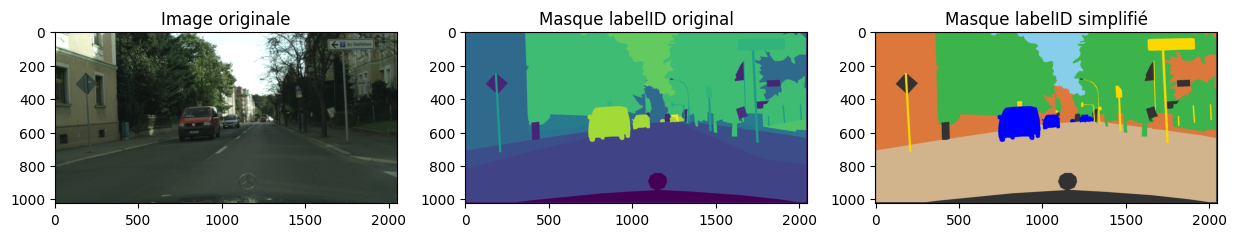

In [34]:
# Chargement d'une image et de son masque correspondant:

idx = 2830  # on peut tester diff√©rents indices
image_path = image_list[idx]
mask_path = mask_list[idx]

# Chargement de l'image
img = image.load_img(image_path)  # sans Resize
img = image.img_to_array(img) / 255.0  # Normalisation

# Chargement du masque
mask = image.load_img(mask_path, color_mode="grayscale")
mask = np.array(mask, dtype=np.uint8)  # Convertir directement en entier pour garder les 8 labels

mask_simplified = make_mask(mask) # Simplification du masque en 8 categs au lieu de 32;
mask_colorized = apply_color_map(mask_simplified) # Colorisation


# Affichage

print(f"Chemin de l'image : {image_path.relative_to(base_dir)}")

fig, ax = plt.subplots(1, 3, figsize=(15, 10))
ax[0].imshow(img)
ax[0].set_title("Image originale")
ax[1].imshow(mask)
ax[1].set_title("Masque labelID original")
ax[2].imshow(mask_colorized)
ax[2].set_title("Masque labelID simplifi√©")
plt.show()

## 2.2. Simplification categs et sauvegardes des masques en .npy

√âtape	           Image	    Mask
Redimensionnement	‚úÖ OUI	    ‚úÖ OUI
Normalisation	    ‚úÖ /255	‚ùå NON
Format final	(H, W, 3), float32	(H, W, 8), one-hot encod√©

In [35]:
save_dir = Path(base_dir) /  "masks_npy"
mask_type = "_gtFine_labelIds"
mask_size = (256, 256)

process_and_save_masks(base_dir, mask_dir, save_dir, mask_type, mask_size)

Processing masks: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 3475/3475 [00:00<00:00, 8334.01it/s]


## 2.3. Data augmentation

In [36]:
# D√©finition des transformations pour l'augmentation
transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
    A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.2, rotate_limit=15, p=0.5),
    A.GridDistortion(num_steps=5, distort_limit=0.3, p=0.3),
    A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.3),
    A.GaussNoise(var_limit=(10, 50), p=0.2),
    A.CoarseDropout(max_holes=5, max_height=50, max_width=50, p=0.3),
], additional_targets={'mask': 'mask'})

C:\Users\flore\Openclassrooms\Projet 8\envP8\Lib\site-packages\albumentations\core\validation.py:87: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
C:\Users\flore\AppData\Local\Temp\ipykernel_11832\1742639297.py:8: UserWarning: Argument(s) 'var_limit' are not valid for transform GaussNoise
  A.GaussNoise(var_limit=(10, 50), p=0.2),
C:\Users\flore\AppData\Local\Temp\ipykernel_11832\1742639297.py:9: UserWarning: Argument(s) 'max_holes, max_height, max_width' are not valid for transform CoarseDropout
  A.CoarseDropout(max_holes=5, max_height=50, max_width=50, p=0.3),


In [37]:
# Dossiers source & destination
base_dir = Path("C:/Users/flore/Openclassrooms/Projet 8/data")
image_dir = base_dir / "original" / "images"
mask_dir = base_dir / "original" / "masks"
augmented_dir = base_dir / "augmented"

In [38]:
# param√©trages:
mask_type = "_gtFine_labelIds"
target_size = (256, 256)

Applique une augmentation aux images et leurs masques, enregistre l'image augment√©e en PNG et le masque en .npy.
Resize (256,256) APRES l'augmentation pour √©viter la perte d'information. resize permet de passer au modele des images l√©g√®res

In [39]:
# Liste des images
image_paths = get_image_paths(image_dir)

for image_path in tqdm.tqdm(image_paths, desc="Processing images & masks"):
    try:

        # 1. Load de l'image
        # -----------------------------------
        
        # D√©terminer le sous-dossier (train ou val)
        relative_path = image_path.relative_to(image_dir)
        subdir = relative_path.parent  # Ex: train ou val

        # V√©rification si le masque existe bien pour l'image donn√©e
        mask_relative_path = image_path.relative_to(image_dir)  # R√©cup√©ration du chemin relatif
        mask_name = image_path.stem.replace("_leftImg8bit", "") # r√©cup√©ration du nom de base sans `_leftImg8bit`
        mask_path = mask_dir / mask_relative_path.parent / f"{mask_name}_gtFine_labelIds.png"

        if not mask_path.exists():
            print(f"Masque non trouv√© pour {image_path.name}, passage...")
            continue

        # Chargement de l'image et du masque sans redimensionnement
        img = image.load_img(image_path)  # Chargement en RGB, taille originale
        mask = image.load_img(mask_path, color_mode="grayscale")  # Chargement en niveaux de gris

        img = np.array(img)
        mask = np.array(mask, dtype=np.uint8)  # Convertir en tableau NumPy

        # V√©rification que tout est OK
        if img is None or mask is None:
            print(f"Probl√®me de chargement pour {image_path.name}, passage...")
            continue


        # 2. AUGMENTATION & RESIZE
        # -----------------------------------
        
        # Appliquer l'augmentation aux images et aux masques
        augmentation = transform(image=img, mask=mask)
        image_aug, mask_aug = augmentation["image"], augmentation["mask"]

        # Resize apr√®s augmentation
        image_aug = cv2.resize(image_aug, target_size, interpolation=cv2.INTER_LINEAR)
        mask_aug = cv2.resize(mask_aug, target_size, interpolation=cv2.INTER_NEAREST)

        # Simplification des cat√©gories du masque (ex: de 34 √† 8 classes)
        mask_simplified = make_mask(mask_aug)


        # 3. Sauvegarde:
        # -----------------------------------
        
        # Construire les chemins de sauvegarde
        save_image_subdir = augmented_dir / "images" / subdir
        save_mask_subdir = augmented_dir / "masks_npy" / subdir  # Stockage des masques en .npy ici

        # Cr√©ation des dossiers parents si n√©cessaire
        save_image_subdir.mkdir(parents=True, exist_ok=True)
        save_mask_subdir.mkdir(parents=True, exist_ok=True)

        # D√©finition des chemins finaux des fichiers sauvegard√©s
        save_image_path = save_image_subdir / f"{image_path.stem}.png"
        save_mask_path = save_mask_subdir / f"{mask_name}_gtFine_labelIds.npy"

        # Sauvegarde des fichiers
        cv2.imwrite(str(save_image_path), image_aug)
        np.save(save_mask_path, mask_simplified, allow_pickle=False)

    except Exception as e:
        print(f"Erreur sur {image_path.name} : {e}")

print("Augmentation termin√©e !")

Processing images & masks: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 3475/3475 [06:10<00:00,  9.39it/s]

Augmentation termin√©e !


# 3. DataGenerator

le DataGenerator est un script python sauvegard√© dans le meme dossier que ce notebook

In [40]:
from DataGenerator import DataGenerator

# param√©trage
batch_size = 32
img_size=(256, 256)

# chemins d'acc√®s (uniquement avec les images d'origines):
base_dir = Path("C:/Users/flore/Openclassrooms/Projet 8/data/original")
train_image_dir = base_dir / "images" / "train"
train_mask_dir = base_dir / "masks_npy"/ "train"
val_image_dir = base_dir / "images" / "val"
val_mask_dir = base_dir / "masks_npy"/ "val"

train_image_paths = get_image_paths (train_image_dir)
train_mask_paths = get_mask_paths (train_mask_dir)
val_image_paths = get_image_paths (val_image_dir)
val_mask_paths = get_mask_paths (val_mask_dir)


# Chemins d'acc√®s images d'origine + images augment√©es:
aug_base_dir = Path("C:/Users/flore/Openclassrooms/Projet 8/data/augmented")
aug_train_image_dir = aug_base_dir / "images" / "train"
aug_train_mask_dir = aug_base_dir / "masks_npy"/ "train"
aug_val_image_dir = aug_base_dir / "images" / "val"
aug_val_mask_dir = aug_base_dir / "masks_npy"/ "val"

aug_train_image_paths = train_image_paths + get_image_paths (aug_train_image_dir)
aug_train_mask_paths = train_mask_paths + get_mask_paths (aug_train_mask_dir)
aug_val_image_paths = val_image_paths + get_image_paths (aug_val_image_dir)
aug_val_mask_paths = val_mask_paths + get_mask_paths (aug_val_mask_dir)


In [41]:
# Instanciation du g√©n√©rateur

train_generator = DataGenerator(
    image_paths=train_image_paths,
    mask_paths=train_mask_paths,
    batch_size=batch_size,
    img_size=img_size,
    num_classes=8,
    # augmentation=transform,
    shuffle=True
)

val_generator = DataGenerator(
    image_paths=val_image_paths,
    mask_paths=val_mask_paths,
    batch_size=batch_size,
    img_size=img_size,
    num_classes=8,
    # augmentation=transform,
    shuffle=False
)

V√©rification du bon fonctionnement du DataGenerator:

In [42]:
print("Taille des images train :", len(train_generator.image_paths))
print("Taille des masques train :", len(train_generator.mask_paths))
print("Taille des images val :", len(val_generator.image_paths))
print("Taille des masques val :", len(val_generator.mask_paths))

Taille des images train : 2975
Taille des masques train : 2975
Taille des images val : 500
Taille des masques val : 500


In [43]:
print(train_generator.image_paths[2500])
print(train_generator.mask_paths[2500])

print(val_generator.image_paths[405])
print(val_generator.mask_paths[405])

C:\Users\flore\Openclassrooms\Projet 8\data\original\images\train\tubingen\tubingen_000028_000019_leftImg8bit.png
C:\Users\flore\Openclassrooms\Projet 8\data\original\masks_npy\train\tubingen\tubingen_000028_000019_gtFine_labelIds.npy
C:\Users\flore\Openclassrooms\Projet 8\data\original\images\val\munster\munster_000079_000019_leftImg8bit.png
C:\Users\flore\Openclassrooms\Projet 8\data\original\masks_npy\val\munster\munster_000079_000019_gtFine_labelIds.npy


In [44]:
#Test du data generator
# R√©cup√©rer un batch
X, Y = train_generator[0]

# V√©rifier les formes des donn√©es
print("Shape des images :", X.shape)  # Doit √™tre (batch_size, img_size, img_size, 3)
print("Shape des masques :", Y.shape)  # Si one-hot activ√© : (batch_size, img_size, img_size)

Shape des images : (32, 256, 256, 3)
Shape des masques : (32, 256, 256)


In [45]:
# Instanciation du g√©n√©rateur avec les images augment√©es

aug_train_generator = DataGenerator(
    image_paths=aug_train_image_paths,
    mask_paths=aug_train_mask_paths,
    batch_size=batch_size,
    img_size=img_size,
    num_classes=8,
    # augmentation=transform,
    shuffle=True
)

aug_val_generator = DataGenerator(
    image_paths=aug_val_image_paths,
    mask_paths=aug_val_mask_paths,
    batch_size=batch_size,
    img_size=img_size,
    num_classes=8,
    # augmentation=transform,
    shuffle=False
)

In [46]:
print("Taille des images aug train :", len(aug_train_generator.image_paths))
print("Taille des masques aug train :", len(aug_train_generator.mask_paths))
print("Taille des images aug val :", len(aug_val_generator.image_paths))
print("Taille des masques aug val :", len(aug_val_generator.mask_paths))

Taille des images aug train : 5950
Taille des masques aug train : 5950
Taille des images aug val : 1000
Taille des masques aug val : 1000


In [47]:
print(aug_train_generator.image_paths[5500])
print(aug_train_generator.mask_paths[5500])

print(aug_val_generator.image_paths[899])
print(aug_val_generator.mask_paths[899])

C:\Users\flore\Openclassrooms\Projet 8\data\augmented\images\train\tubingen\tubingen_000053_000019_leftImg8bit.png
C:\Users\flore\Openclassrooms\Projet 8\data\augmented\masks_npy\train\tubingen\tubingen_000053_000019_gtFine_labelIds.npy
C:\Users\flore\Openclassrooms\Projet 8\data\augmented\images\val\munster\munster_000073_000019_leftImg8bit.png
C:\Users\flore\Openclassrooms\Projet 8\data\augmented\masks_npy\val\munster\munster_000073_000019_gtFine_labelIds.npy


# 4.Modeles

## 4.1 U-Net Mini

### 4.1 Definition modele

In [48]:
# def conv_block(tensor, nfilters, size=3, padding='same', initializer="he_normal", dropout=False):
#     """Bloc convolutionnel avec BatchNorm et Dropout optionnel"""
#     x = layers.Conv2D(nfilters, (size, size), padding=padding, kernel_initializer=initializer)(tensor)
#     x = layers.BatchNormalization()(x)
#     x = layers.Activation("relu")(x)
#     x = layers.Conv2D(nfilters, (size, size), padding=padding, kernel_initializer=initializer)(x)
#     x = layers.BatchNormalization()(x)
#     x = layers.Activation("relu")(x)
#     if dropout:
#         x = layers.Dropout(0.5)(x)
#     return x

# def unet_mini(input_shape=(128, 128, 3), num_classes=8):
#     inputs = layers.Input(input_shape)

#     # --- ENCODER ---
#     x1 = conv_block(inputs, 32)  # 128x128
#     p1 = layers.MaxPooling2D((2, 2))(x1)  # 64x64

#     x2 = conv_block(p1, 64)
#     p2 = layers.MaxPooling2D((2, 2))(x2)  # 32x32

#     # --- BOTTLENECK ---
#     b = conv_block(p2, 128, dropout=True)  # 32x32

#     # --- DECODER ---
#     u2 = layers.Conv2DTranspose(64, (3, 3), strides=2, padding='same')(b)  # 32x32 -> 64x64
#     u2 = layers.Concatenate()([u2, x2])
#     u2 = conv_block(u2, 64, dropout=True)

#     u3 = layers.Conv2DTranspose(32, (3, 3), strides=2, padding='same')(u2)  # 64x64 -> 128x128
#     u3 = layers.Concatenate()([u3, x1])
#     u3 = conv_block(u3, 32, dropout=True)

#     # --- OUTPUT ---
#     outputs = layers.Conv2D(num_classes, (1, 1), activation='softmax')(u3)

#     model = models.Model(inputs, outputs)
#     return model
    
# # Cr√©ation du mod√®le
# model = unet_mini()
# model.summary()

In [49]:
def conv_block(tensor, nfilters, size=3, padding='same', initializer="he_normal", dropout=False):
    """Bloc convolutionnel avec BatchNorm et Dropout optionnel"""
    x = layers.Conv2D(nfilters, (size, size), padding=padding, kernel_initializer=initializer)(tensor)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.Conv2D(nfilters, (size, size), padding=padding, kernel_initializer=initializer)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    if dropout:
        x = layers.Dropout(0.5)(x)
    return x

def unet_mini(input_shape=(256, 256, 3), num_classes=8):
    inputs = layers.Input(input_shape)

    # --- ENCODER ---
    x1 = conv_block(inputs, 32)  # 256x256
    p1 = layers.MaxPooling2D((2, 2))(x1)  # 128x128

    x2 = conv_block(p1, 64)  
    p2 = layers.MaxPooling2D((2, 2))(x2)  # 64x64

    x3 = conv_block(p2, 128)  
    p3 = layers.MaxPooling2D((2, 2))(x3)  # 32x32

    # --- BOTTLENECK ---
    b = conv_block(p3, 256, dropout=True)  # 32x32

    # --- DECODER ---
    u1 = layers.Conv2DTranspose(128, (3, 3), strides=2, padding='same')(b)  # 32x32 -> 64x64
    u1 = layers.Concatenate()([u1, x3])
    u1 = conv_block(u1, 128, dropout=True)

    u2 = layers.Conv2DTranspose(64, (3, 3), strides=2, padding='same')(u1)  # 64x64 -> 128x128
    u2 = layers.Concatenate()([u2, x2])
    u2 = conv_block(u2, 64, dropout=True)

    u3 = layers.Conv2DTranspose(32, (3, 3), strides=2, padding='same')(u2)  # 128x128 -> 256x256
    u3 = layers.Concatenate()([u3, x1])
    u3 = conv_block(u3, 32, dropout=True)

    # --- OUTPUT ---
    outputs = layers.Conv2D(num_classes, (1, 1), activation='softmax')(u3) 

    model = models.Model(inputs, outputs)
    return model

# Cr√©ation du mod√®le
model = unet_mini()
model.summary()

Model: "functional"

‚îè‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îì
‚îÉ Layer (type)                  ‚îÉ Output Shape              ‚îÉ         Param # ‚îÉ Connected to               ‚îÉ
‚î°‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î©
‚îÇ input_layer (InputLayer)      ‚îÇ (None, 256, 256, 3)       ‚îÇ               0 ‚îÇ -                          ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ conv2d (Conv2D)               ‚îÇ (None, 256, 256, 32)      ‚îÇ             896 ‚îÇ input_layer[0][0]          ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ batch_normalization           ‚îÇ (None, 256, 256, 32)      ‚îÇ             128 ‚îÇ conv2d[0][0]               ‚îÇ
‚îÇ (BatchNormalization)          ‚îÇ                           ‚îÇ                 ‚îÇ                            ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ activation (Activation)       ‚îÇ (None, 256, 256, 32)      ‚îÇ               0 ‚îÇ batch_normalization[0][0]  ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ conv2d_1 (Conv2D)             ‚îÇ (None, 256, 256, 32)      ‚îÇ           9,248 ‚îÇ activation[0][0]           ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ batch_normalization_1         ‚îÇ (None, 256, 256, 32)      ‚îÇ             128 ‚îÇ conv2d_1[0][0]             ‚îÇ
‚îÇ (BatchNormalization)          ‚îÇ                           ‚îÇ                 ‚îÇ                            ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ activation_1 (Activation)     ‚îÇ (None, 256, 256, 32)      ‚îÇ               0 ‚îÇ batch_normalization_1[0][‚Ä¶ ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚

 Total params: 2,146,504 (8.19 MB)

 Trainable params: 2,143,688 (8.18 MB)

 Non-trainable params: 2,816 (11.00 KB)

### 4.1.2 Sans data augmentation

In [50]:
log_dir = Path("C:/Users/flore/Openclassrooms/Projet 8/logs/fit/" ) # R√©pertoire pour les logs de TensorBoard
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1) #initialisation du callback tensorboard

In [51]:
print(multiprocessing.cpu_count())  # Nombre total de c≈ìurs logiques

12


In [52]:
# param√©trages
epochs=30
model = unet_mini()
model_name = "unet_mini"
checkpoint_path = f"models/{model_name}.keras"

Chargement du mod√®le existant : models/unet_mini.keras
Contenu de l'historique charg√© depuis le fichier :
{'loss': [0.3840488791465759, 0.38198503851890564, 0.36705273389816284, 0.3594039976596832, 0.3581579029560089], 'mean_iou': [0.6272938251495361, 0.628699004650116, 0.6382569074630737, 0.6439926028251648, 0.6448698043823242], 'val_loss': [0.41577234864234924, 0.40483763813972473, 0.5113842487335205, 0.42997926473617554, 0.4287087619304657], 'val_mean_iou': [0.6209688186645508, 0.6162967681884766, 0.5837205648422241, 0.6050277352333069, 0.6301192045211792], 'learning_rate': [0.0010000000474974513, 0.0010000000474974513, 0.0010000000474974513, 0.0010000000474974513, 0.0010000000474974513]}

Historique de validation ('val_loss') trouv√© : [0.41577234864234924, 0.40483763813972473, 0.5113842487335205, 0.42997926473617554, 0.4287087619304657]
Le mod√®le unet_mini est d√©j√† flagu√© comme optimis√©. Pas besoin de reprendre l'entra√Ænement.


2025/03/16 15:41:25 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2025/03/16 15:41:33 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: C:\Users\flore\AppData\Local\Temp\tmpvf7ldt53\model, flavor: keras). Fall back to return ['keras==3.8.0']. Set logging level to DEBUG to see the full traceback. 
2025/03/16 15:41:33 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 3s 3s/step
1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 2s 2s/step
1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 3s 3s/step
1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 2s 2s/step
1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 2s 2s/step
1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 2s 2s/step
1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 2s 2s/step
1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 2s 2s/step
1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 2s 2s/step
1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 2s 2s/step
1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 2s 2s/step
1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 2s 2s/step
1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 2s 2s/step
1/1 ‚îÅ‚îÅ‚î

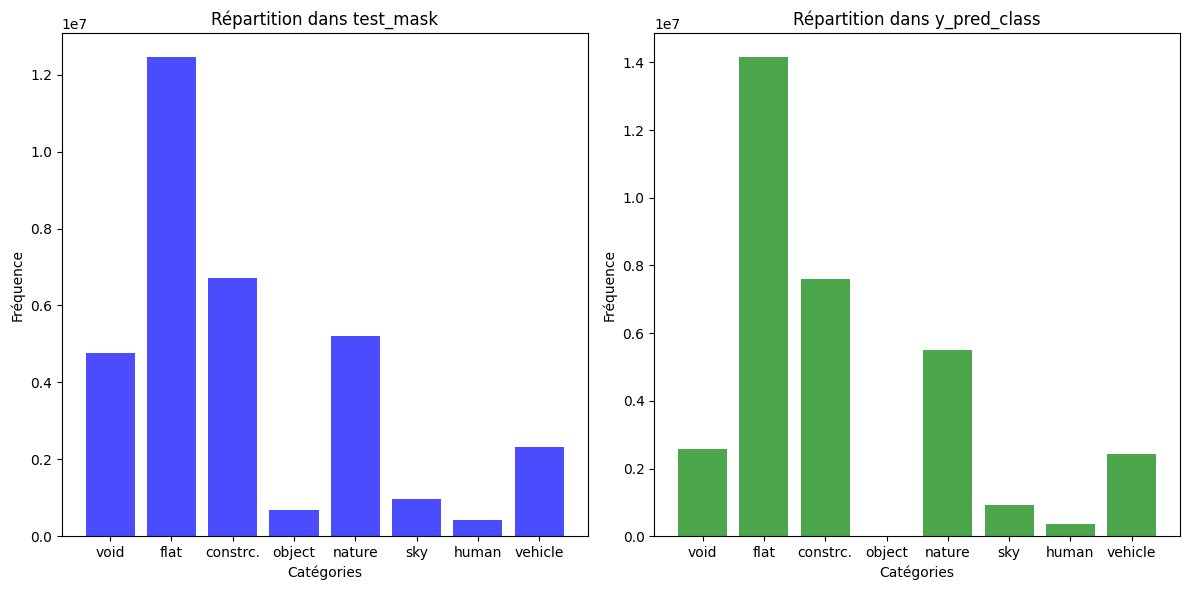

üèÉ View run unet_mini - sans data augm. at: http://127.0.0.1:5000/#/experiments/615947391303416845/runs/d37aeb3093e94459818f99f75bf311af
üß™ View experiment at: http://127.0.0.1:5000/#/experiments/615947391303416845


In [53]:
with mlflow.start_run(run_name=f"{model_name} - sans data augm."):

    #mlflow.set_tag("Approach", "sans data augm.")

    #----------------------------
    # Hyperparam√®tres
    params = {
        "optimizer": "Adam",
        "learning_rate": 0.001,
        "loss": "sparse_categorical_crossentropy"
    }
    mlflow.log_params(params) #log des param√®tres


    #----------------------------
    # Compile & entra√Ænement
    history = train_pipeline(model, model_name, params, train_generator, val_generator, epochs, checkpoint_path)

    
    #----------------------------
    # Log du mod√®le dans MLFlow
    model = tf.keras.models.load_model(checkpoint_path)
    # temp_ex_dir = "models/temp_example"
    # input_example = np.expand_dims(train_generator[0][0][0], axis=0)  # Une seule image avec batch dim
    mlflow.keras.log_model(model, model_name) #, input_example=input_example, artifact_path=temp_ex_dir)

    #----------------------------
    # Calculs et log des metrics du mod√®le dans MLFlow
    mean_iou, iou_per_class, mean_dice = evaluate_and_plot_class_distribution(model, val_generator)

    mlflow.log_metric("mIoU", mean_iou)
    mlflow.log_metric("Mean Dice", mean_dice)
    
    for i, value in enumerate(iou_per_class):
        mlflow.log_metric(f"IoU_Class_{i}", value)

1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 1s 506ms/step


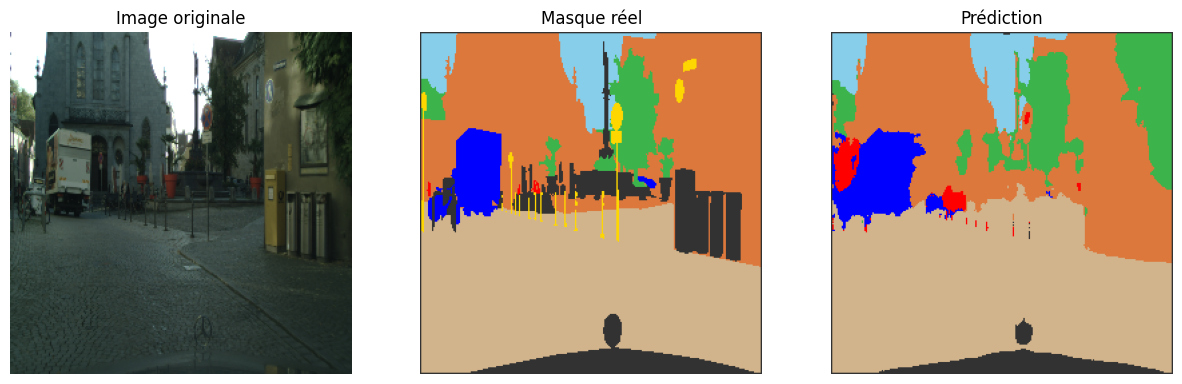

In [54]:
# S√©lection d'images test pour visualitation

photo_indexes = [(9, 2), (6, 27), (10, 15)] 

for batch_index, img_nb in photo_indexes:
    visualisation_img_test(model, batch_index, img_nb)

### 4.1.3 Avec data augmentation

In [55]:
# param√©trages
epochs=30
model = unet_mini()
model_name = "unet_mini_aug"
checkpoint_path = f"models/{model_name}.keras"

Chargement du mod√®le existant : models/unet_mini_aug.keras
Contenu de l'historique charg√© depuis le fichier :
{'loss': [0.5151879787445068, 0.49882376194000244, 0.47845396399497986, 0.4664267599582672, 0.4623492658138275, 0.44446584582328796, 0.43028703331947327, 0.4267589747905731, 0.4207395911216736, 0.40993303060531616], 'mean_iou': [0.5665924549102783, 0.572553277015686, 0.5843529105186462, 0.5910084247589111, 0.5932477712631226, 0.6025571823120117, 0.610139012336731, 0.6132087707519531, 0.6170942783355713, 0.623112142086029], 'val_loss': [0.6362989544868469, 0.6648175716400146, 0.5230246186256409, 0.5011158585548401, 0.5983687043190002, 0.4854472875595093, 0.467896044254303, 0.5276074409484863, 0.4904725253582001, 0.4939175546169281], 'val_mean_iou': [0.5072876214981079, 0.5178812742233276, 0.5701573491096497, 0.5552370548248291, 0.5440671443939209, 0.5881800651550293, 0.6000532507896423, 0.5884338617324829, 0.5943582057952881, 0.5940490365028381], 'learning_rate': [0.0010000000

2025/03/16 15:42:38 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2025/03/16 15:42:44 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: C:\Users\flore\AppData\Local\Temp\tmp29_s3qbl\model, flavor: keras). Fall back to return ['keras==3.8.0']. Set logging level to DEBUG to see the full traceback. 
2025/03/16 15:42:44 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 3s 3s/step
1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 2s 2s/step
1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 2s 2s/step
1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 2s 2s/step
1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 2s 2s/step
1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 2s 2s/step
1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 2s 2s/step
1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 3s 3s/step
1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 2s 2s/step
1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 2s 2s/step
1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 3s 3s/step
1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 2s 2s/step
1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 2s 2s/step
1/1 ‚îÅ‚îÅ‚î

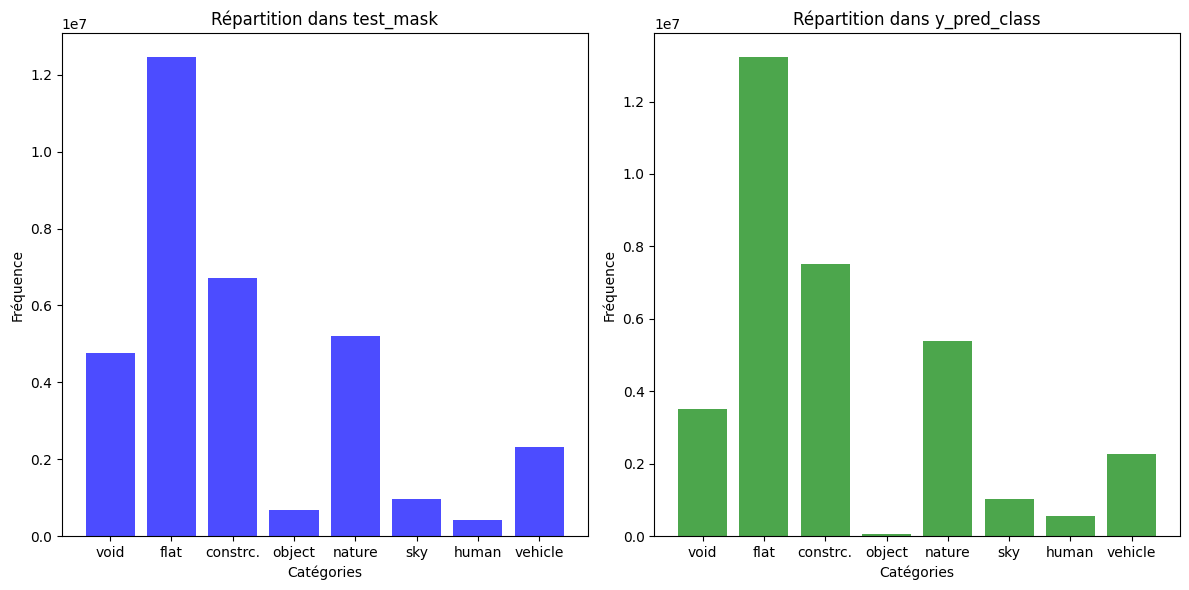

üèÉ View run unet_mini_aug - avec data augm. at: http://127.0.0.1:5000/#/experiments/615947391303416845/runs/2027495820654569ad78fa8d4ff36fa1
üß™ View experiment at: http://127.0.0.1:5000/#/experiments/615947391303416845


In [56]:
with mlflow.start_run(run_name=f"{model_name} - avec data augm."):

    #mlflow.set_tag("Approach", "avc data augm.")

    #----------------------------
    # Hyperparam√®tres
    params = {
        "optimizer": "Adam",
        "learning_rate": 0.001,
        "loss": "sparse_categorical_crossentropy"
    }
    mlflow.log_params(params) #log des param√®tres


    #----------------------------
    # Compile & entra√Ænement
    history = train_pipeline(model, model_name, params, aug_train_generator, aug_val_generator, epochs, checkpoint_path)

    
    #----------------------------
    # Log du mod√®le dans MLFlow
    model = tf.keras.models.load_model(checkpoint_path)
    # temp_ex_dir = "models/temp_example"
    # input_example = np.expand_dims(train_generator[0][0][0], axis=0)  # Une seule image avec batch dim
    mlflow.keras.log_model(model, model_name) #, input_example=input_example, artifact_path=temp_ex_dir)

    #----------------------------
    # Calculs et log des metrics du mod√®le dans MLFlow
    mean_iou, iou_per_class, mean_dice = evaluate_and_plot_class_distribution(model, val_generator)

    mlflow.log_metric("mIoU", mean_iou)
    mlflow.log_metric("Mean Dice", mean_dice)
    
    for i, value in enumerate(iou_per_class):
        mlflow.log_metric(f"IoU_Class_{i}", value)

1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 467ms/step


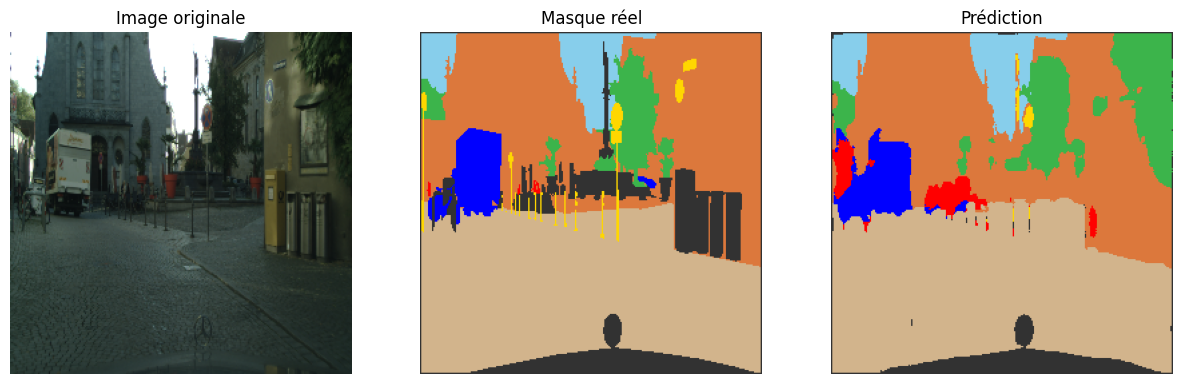

In [57]:
# S√©lection d'images test pour visualitation

photo_indexes = [(9, 2), (6, 27), (10, 15)] 

for batch_index, img_nb in photo_indexes:
    visualisation_img_test(model, batch_index, img_nb)

## 4.2 VGG16-U-Net

### 4.1 Definition mod√®le

In [58]:
# def conv_block(tensor, nfilters, size=3, padding='same', initializer="he_normal", dropout=False):
#     """Bloc convolutionnel avec BatchNorm et Dropout optionnel"""
#     x = layers.Conv2D(nfilters, (size, size), padding=padding, kernel_initializer=initializer)(tensor)
#     x = layers.BatchNormalization()(x)
#     x = layers.Activation("relu")(x)
#     x = layers.Conv2D(nfilters, (size, size), padding=padding, kernel_initializer=initializer)(x)
#     x = layers.BatchNormalization()(x)
#     x = layers.Activation("relu")(x)
#     if dropout:
#         x = layers.Dropout(0.5)(x)
#     return x

# def unet_vgg16(input_shape=(128, 128, 3), num_classes=8):
#     inputs = layers.Input(input_shape)

#     # --- ENCODER : Utilisation de VGG16 pr√©-entrain√© sans la couche top (classification) ---
#     vgg16 = VGG16(weights="imagenet", include_top=False, input_tensor=inputs)
#     vgg16.trainable = False  # On garde les poids de VGG16 fixes

#     # Utilisation des sorties de VGG16 pour notre encodeur
#     x1 = vgg16.get_layer("block1_conv2").output  # 128x128
#     x2 = vgg16.get_layer("block2_conv2").output  # 64x64
#     x3 = vgg16.get_layer("block3_conv3").output  # 32x32
#     x4 = vgg16.get_layer("block4_conv3").output  # 16x16

#     # --- BOTTLENECK ---
#     b = conv_block(x4, 512, dropout=True)  # 16x16

#     # --- DECODER ---
#     u4 = layers.Conv2DTranspose(256, (3, 3), strides=2, padding='same')(b)  # 16x16 -> 32x32
#     u4 = layers.Concatenate()([u4, x3])
#     u4 = conv_block(u4, 256, dropout=True)

#     u3 = layers.Conv2DTranspose(128, (3, 3), strides=2, padding='same')(u4)  # 32x32 -> 64x64
#     u3 = layers.Concatenate()([u3, x2])
#     u3 = conv_block(u3, 128, dropout=True)

#     u2 = layers.Conv2DTranspose(64, (3, 3), strides=2, padding='same')(u3)  # 64x64 -> 128x128
#     u2 = layers.Concatenate()([u2, x1])
#     u2 = conv_block(u2, 64, dropout=True)

#     # --- OUTPUT ---
#     outputs = layers.Conv2D(num_classes, (1, 1), activation='softmax')(u2)

#     model = models.Model(inputs, outputs)
#     return model

# # Cr√©ation du mod√®le avec VGG16 comme encodeur
# model = unet_vgg16()
# model.summary()

In [59]:
def conv_block(tensor, nfilters, size=3, padding='same', initializer="he_normal", dropout=False):
    """Bloc convolutionnel avec BatchNorm et Dropout optionnel"""
    x = layers.Conv2D(nfilters, (size, size), padding=padding, kernel_initializer=initializer)(tensor)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.Conv2D(nfilters, (size, size), padding=padding, kernel_initializer=initializer)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    if dropout:
        x = layers.Dropout(0.5)(x)
    return x

def unet_vgg16(input_shape=(256, 256, 3), num_classes=8):
    inputs = layers.Input(input_shape)

    # --- ENCODER : Utilisation de VGG16 pr√©-entrain√© sans la couche top (classification) ---
    vgg16 = VGG16(weights="imagenet", include_top=False, input_tensor=inputs)
    vgg16.trainable = False  # On garde les poids de VGG16 fixes

    # Utilisation des sorties de VGG16 pour notre encodeur
    x1 = vgg16.get_layer("block1_conv2").output  # 256x256
    x2 = vgg16.get_layer("block2_conv2").output  # 128x128
    x3 = vgg16.get_layer("block3_conv3").output  # 64x64
    x4 = vgg16.get_layer("block4_conv3").output  # 32x32

    # --- BOTTLENECK ---
    b = conv_block(x4, 512, dropout=True)  # 32x32

    # --- DECODER ---
    u4 = layers.Conv2DTranspose(256, (3, 3), strides=2, padding='same')(b)  # 32x32 -> 64x64
    u4 = layers.Concatenate()([u4, x3])
    u4 = conv_block(u4, 256, dropout=True)

    u3 = layers.Conv2DTranspose(128, (3, 3), strides=2, padding='same')(u4)  # 64x64 -> 128x128
    u3 = layers.Concatenate()([u3, x2])
    u3 = conv_block(u3, 128, dropout=True)

    u2 = layers.Conv2DTranspose(64, (3, 3), strides=2, padding='same')(u3)  # 128x128 -> 256x256
    u2 = layers.Concatenate()([u2, x1])
    u2 = conv_block(u2, 64, dropout=True)

    # --- OUTPUT ---
    outputs = layers.Conv2D(num_classes, (1, 1), activation='softmax')(u2)

    model = models.Model(inputs, outputs)
    return model

# Cr√©ation du mod√®le avec VGG16 comme encodeur pour 256x256
model = unet_vgg16(input_shape=(256, 256, 3))
model.summary()

Model: "functional_3"

‚îè‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îì
‚îÉ Layer (type)                  ‚îÉ Output Shape              ‚îÉ         Param # ‚îÉ Connected to               ‚îÉ
‚î°‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î©
‚îÇ input_layer_3 (InputLayer)    ‚îÇ (None, 256, 256, 3)       ‚îÇ               0 ‚îÇ -                          ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ block1_conv1 (Conv2D)         ‚îÇ (None, 256, 256, 64)      ‚îÇ           1,792 ‚îÇ input_layer_3[0][0]        ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ block1_conv2 (Conv2D)         ‚îÇ (None, 256, 256, 64)      ‚îÇ          36,928 ‚îÇ block1_conv1[0][0]         ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ block1_pool (MaxPooling2D)    ‚îÇ (None, 128, 128, 64)      ‚îÇ               0 ‚îÇ block1_conv2[0][0]         ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ block2_conv1 (Conv2D)         ‚îÇ (None, 128, 128, 128)     ‚îÇ          73,856 ‚îÇ block1_pool[0][0]          ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ block2_conv2 (Conv2D)         ‚îÇ (None, 128, 128, 128)     ‚îÇ         147,584 ‚îÇ block2_conv1[0][0]         ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ block2_pool (MaxPooling2D)    ‚îÇ (None, 64, 64, 128)       ‚îÇ               0 ‚îÇ block2_conv2[0][0]         ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ block3_conv1 (Conv2D)         ‚îÇ (None, 64, 64, 256)       ‚îÇ         295,168 ‚îÇ block2_pool[0][0]          ‚îÇ
‚îú‚

 Total params: 16,235,144 (61.93 MB)

 Trainable params: 8,596,040 (32.79 MB)

 Non-trainable params: 7,639,104 (29.14 MB)

### 4.2.2 Sans data augmentation

In [60]:
# param√©trages
epochs=30
model_name = "VGG16_unet"
checkpoint_path = f"models/{model_name}.keras"

Chargement du mod√®le existant : models/VGG16_unet.keras
Contenu de l'historique charg√© depuis le fichier :
{'loss': [0.39305800199508667, 0.37377068400382996, 0.35312145948410034, 0.3410923182964325, 0.32689082622528076, 0.31952738761901855, 0.3153018653392792, 0.29705336689949036, 0.2899166941642761], 'mean_iou': [0.628967821598053, 0.6447086334228516, 0.6619467735290527, 0.6718911528587341, 0.6839867830276489, 0.6893916130065918, 0.6941721439361572, 0.706082820892334, 0.7104939222335815], 'val_loss': [0.45682188868522644, 0.4212786853313446, 0.40086621046066284, 0.4109954535961151, 0.4271661043167114, 0.3939637839794159, 0.4186602532863617, 0.3977365791797638, 0.41112640500068665], 'val_mean_iou': [0.5888763666152954, 0.616324782371521, 0.6277478933334351, 0.6351626515388489, 0.6379908919334412, 0.6540126204490662, 0.6456689834594727, 0.648197591304779, 0.6560918092727661], 'learning_rate': [0.0010000000474974513, 0.0010000000474974513, 0.0010000000474974513, 0.0010000000474974513,

2025/03/16 15:43:50 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2025/03/16 15:43:57 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: C:\Users\flore\AppData\Local\Temp\tmpdodv_j4w\model, flavor: keras). Fall back to return ['keras==3.8.0']. Set logging level to DEBUG to see the full traceback. 
2025/03/16 15:43:57 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 11s 11s/step
1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 14s 14s/step
1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 10s 10s/step
1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 11s 11s/step
1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 10s 10s/step
1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 10s 10s/step
1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 10s 10s/step
1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 10s 10s/step
1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 10s 10s/step
1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 10s 10s/step
1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 10s 10s/step
1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 10s 10s/step
1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ

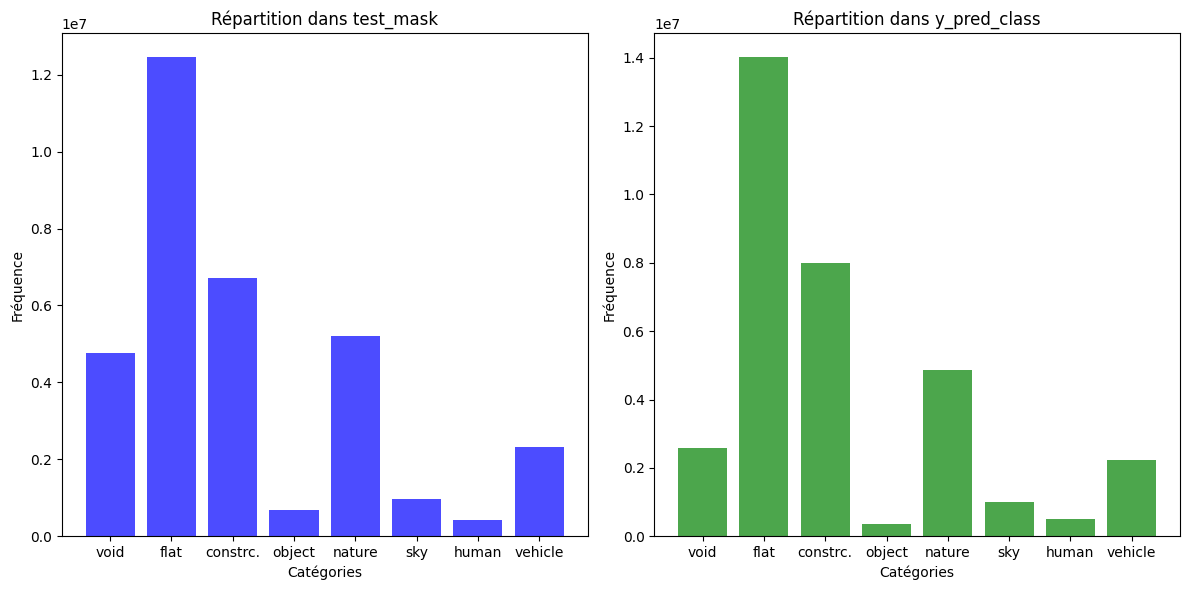

üèÉ View run VGG16_unet - sans data augm. at: http://127.0.0.1:5000/#/experiments/615947391303416845/runs/8e975e17c78c4376837e10de32c3ced8
üß™ View experiment at: http://127.0.0.1:5000/#/experiments/615947391303416845


In [61]:
with mlflow.start_run(run_name=f"{model_name} - sans data augm."):

    #mlflow.set_tag("Approach", "sans data augm.")

    #----------------------------
    # Hyperparam√®tres
    params = {
        "optimizer": "Adam",
        "learning_rate": 0.001,
        "loss": "sparse_categorical_crossentropy"
    }
    mlflow.log_params(params) #log des param√®tres


    #----------------------------
    # Compile & entra√Ænement
    history = train_pipeline(model, model_name, params, train_generator, val_generator, epochs, checkpoint_path)

    
    #----------------------------
    # Log du mod√®le dans MLFlow
    model = tf.keras.models.load_model(checkpoint_path)
    # temp_ex_dir = "models/temp_example"
    # input_example = np.expand_dims(train_generator[0][0][0], axis=0)  # Une seule image avec batch dim
    mlflow.keras.log_model(model, model_name) #, input_example=input_example, artifact_path=temp_ex_dir)

    #----------------------------
    # Calculs et log des metrics du mod√®le dans MLFlow
    mean_iou, iou_per_class, mean_dice = evaluate_and_plot_class_distribution(model, val_generator)

    mlflow.log_metric("mIoU", mean_iou)
    mlflow.log_metric("Mean Dice", mean_dice)
    
    for i, value in enumerate(iou_per_class):
        mlflow.log_metric(f"IoU_Class_{i}", value)

1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 1s 1s/step


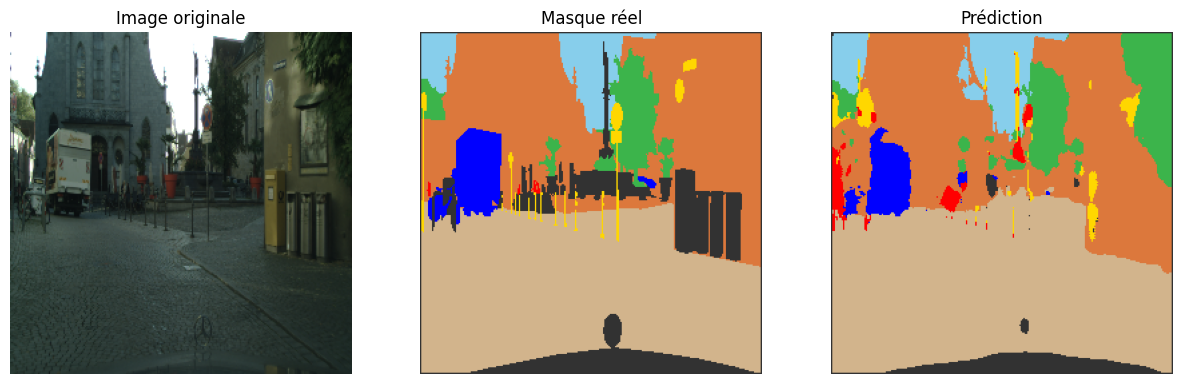

In [62]:
# S√©lection d'images test pour visualitation

photo_indexes = [(9, 2), (6, 27), (10, 15)] 

for batch_index, img_nb in photo_indexes:
    visualisation_img_test(model, batch_index, img_nb)

### 4.2.3 Avec data augmentation

In [65]:
# param√©trages
epochs=30
model = unet_vgg16(input_shape=(256, 256, 3))
model_name = "VGG16_unet_aug"
checkpoint_path = f"models/{model_name}.keras"

In [ ]:
with mlflow.start_run(run_name=f"{model_name} - avec data augm."):

    #mlflow.set_tag("Approach", "avc data augm.")

    #----------------------------
    # Hyperparam√®tres
    params = {
        "optimizer": "Adam",
        "learning_rate": 0.001,
        "loss": "sparse_categorical_crossentropy"
    }
    mlflow.log_params(params) #log des param√®tres


    #----------------------------
    # Compile & entra√Ænement
    history = train_pipeline(model, model_name, params, aug_train_generator, aug_val_generator, epochs, checkpoint_path)

    
    #----------------------------
    # Log du mod√®le dans MLFlow
    model = tf.keras.models.load_model(checkpoint_path)
    # temp_ex_dir = "models/temp_example"
    # input_example = np.expand_dims(train_generator[0][0][0], axis=0)  # Une seule image avec batch dim
    mlflow.keras.log_model(model, model_name) #, input_example=input_example, artifact_path=temp_ex_dir)

    #----------------------------
    # Calculs et log des metrics du mod√®le dans MLFlow
    mean_iou, iou_per_class, mean_dice = evaluate_and_plot_class_distribution(model, val_generator)

    mlflow.log_metric("mIoU", mean_iou)
    mlflow.log_metric("Mean Dice", mean_dice)
    
    for i, value in enumerate(iou_per_class):
        mlflow.log_metric(f"IoU_Class_{i}", value)

Chargement du mod√®le existant : models/VGG16_unet_aug.keras
Contenu de l'historique charg√© depuis le fichier :
{'loss': [0.7884799242019653, 0.570934534072876, 0.5203260183334351], 'mean_iou': [0.44070541858673096, 0.5267995595932007, 0.5614590644836426], 'val_loss': [0.8867020606994629, 0.6020273566246033, 0.5411856174468994], 'val_mean_iou': [0.4334659278392792, 0.5220197439193726, 0.556739091873169], 'learning_rate': [0.0010000000474974513, 0.0010000000474974513, 0.0010000000474974513]}

Historique de validation ('val_loss') trouv√© : [0.8867020606994629, 0.6020273566246033, 0.5411856174468994]
Le mod√®le n'est pas encore optimal. Reprise de l'entra√Ænement.


C:\Users\flore\Openclassrooms\Projet 8\envP8\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
  6/185 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 1:49:32 37s/step - loss: 0.5388 - mean_iou: 0.5667

In [ ]:
# S√©lection d'images test pour visualitation

photo_indexes = [(9, 2), (6, 27), (10, 15)] 

for batch_index, img_nb in photo_indexes:
    visualisation_img_test(model, batch_index, img_nb)

## 4.3 ResNet 50

### 4.1 Definition mod√®le

ResNet50 comme encodeur

On charge ResNet50 sans la partie fully connected (include_top=False).
On r√©cup√®re des couches cl√©s (conv1_relu, conv2_block3_out, ...) pour le skip connections de U-Net.
Par d√©faut, on g√®le les poids de ResNet pour √©viter d‚Äô√©craser ses features.
Bottleneck

On prend la derni√®re couche convolutive du ResNet avant de d√©compresser les features.
D√©codeur (Decoder)

Chaque bloc du d√©codeur utilise Conv2DTranspose (upsampling) suivi de concat√©nation avec les features du ResNet.
On garde la m√™me structure que ton U-Net mini, mais en partant d‚Äôun encodeur plus puissant.
Sortie (Output Layer)

Conv2D(num_classes, (1,1), activation="softmax") pour segmentation multi-classes.

In [ ]:
def resnet_unet(input_shape=(224, 224, 3), num_classes=8, fine_tune=False):
    inputs = layers.Input(input_shape)

    # Pr√©processing des images pour ResNet
    x = applications.resnet50.preprocess_input(inputs)

    # Charger ResNet50 pr√©-entra√Æn√© sur ImageNet sans les couches fully connected
    base_model = applications.ResNet50(weights="imagenet", include_top=False, input_tensor=x)
    
    # Geler les poids du backbone sauf si fine-tuning activ√©
    if not fine_tune:
        base_model.trainable = False
    else:
        # D√©geler les 10 derni√®res couches du ResNet pour qu'elles continuent d'apprendre sur le dataset.
        for layer in base_model.layers[-10:]:  # Derni√®res 10 couches
            layer.trainable = True
            
    # Extraction des features maps
    x1 = base_model.get_layer("conv1_relu").output  # 112x112
    x2 = base_model.get_layer("conv2_block3_out").output  # 56x56
    x3 = base_model.get_layer("conv3_block4_out").output  # 28x28
    x4 = base_model.get_layer("conv4_block6_out").output  # 14x14
    b = base_model.get_layer("conv5_block3_out").output  # 7x7

    # DECODER (Upsampling + Concatenation)
    u4 = layers.Conv2DTranspose(512, (3,3), strides=2, padding="same")(b)
    u4 = layers.Concatenate()([u4, x4])
    u4 = layers.Conv2D(512, (3,3), activation="relu", padding="same")(u4)

    u3 = layers.Conv2DTranspose(256, (3,3), strides=2, padding="same")(u4)
    u3 = layers.Concatenate()([u3, x3])
    u3 = layers.Conv2D(256, (3,3), activation="relu", padding="same")(u3)

    u2 = layers.Conv2DTranspose(128, (3,3), strides=2, padding="same")(u3)
    u2 = layers.Concatenate()([u2, x2])
    u2 = layers.Conv2D(128, (3,3), activation="relu", padding="same")(u2)

    u1 = layers.Conv2DTranspose(64, (3,3), strides=2, padding="same")(u2)
    u1 = layers.Concatenate()([u1, x1])  
    u1 = layers.Conv2D(64, (3,3), activation="relu", padding="same")(u1)

    u0 = layers.Conv2DTranspose(32, (3,3), strides=2, padding="same")(u1)
    u0 = layers.Conv2D(32, (3,3), activation="relu", padding="same")(u0)

    outputs = layers.Conv2D(num_classes, (1,1), activation="softmax")(u0)

    model = models.Model(inputs, outputs)
    return model

# Cr√©ation du mod√®le
model = resnet_unet()
model.summary()

### 4.2.2 Sans data augmentation

In [ ]:
# param√©trages
epochs=30
model = resnet_unet()
model_name = "resnet"
checkpoint_path = f"models/{model_name}.keras"

In [ ]:
img_size=(224,224)

# Instanciation du g√©n√©rateur

train_generator = DataGenerator(
    image_paths=train_image_paths,
    mask_paths=train_mask_paths,
    batch_size=batch_size,
    img_size=img_size,
    num_classes=8,
    # augmentation=transform,
    shuffle=True
)

val_generator = DataGenerator(
    image_paths=val_image_paths,
    mask_paths=val_mask_paths,
    batch_size=batch_size,
    img_size=img_size,
    num_classes=8,
    # augmentation=transform,
    shuffle=False
)

In [ ]:
with mlflow.start_run(run_name=f"{model_name} - sans data augm."):

    #mlflow.set_tag("Approach", "sans data augm.")

    #----------------------------
    # Hyperparam√®tres
    params = {
        "optimizer": "Adam",
        "learning_rate": 0.001,
        "loss": "sparse_categorical_crossentropy"
    }
    mlflow.log_params(params) #log des param√®tres


    #----------------------------
    # Compile & entra√Ænement
    history = train_pipeline(model, model_name, params, train_generator, val_generator, epochs, checkpoint_path)

    
    #----------------------------
    # Log du mod√®le dans MLFlow
    model = tf.keras.models.load_model(checkpoint_path)
    # temp_ex_dir = "models/temp_example"
    # input_example = np.expand_dims(train_generator[0][0][0], axis=0)  # Une seule image avec batch dim
    mlflow.keras.log_model(model, model_name) #, input_example=input_example, artifact_path=temp_ex_dir)

    #----------------------------
    # Calculs et log des metrics du mod√®le dans MLFlow
    mean_iou, iou_per_class, mean_dice = evaluate_and_plot_class_distribution(model, val_generator)

    mlflow.log_metric("mIoU", mean_iou)
    mlflow.log_metric("Mean Dice", mean_dice)
    
    for i, value in enumerate(iou_per_class):
        mlflow.log_metric(f"IoU_Class_{i}", value)

In [ ]:
# S√©lection d'images test pour visualitation

photo_indexes = [(9, 2), (6, 27), (10, 15)] 

for batch_index, img_nb in photo_indexes:
    visualisation_img_test(model, batch_index, img_nb)

### 4.2.3 Avec data augmentation

In [ ]:
# Instanciation du g√©n√©rateur avec les images augment√©es

img_size=(224,224)

aug_train_generator = DataGenerator(
    image_paths=aug_train_image_paths,
    mask_paths=aug_train_mask_paths,
    batch_size=batch_size,
    img_size=img_size,
    num_classes=8,
    # augmentation=transform,
    shuffle=True
)

aug_val_generator = DataGenerator(
    image_paths=aug_val_image_paths,
    mask_paths=aug_val_mask_paths,
    batch_size=batch_size,
    img_size=img_size,
    num_classes=8,
    # augmentation=transform,
    shuffle=False
)

In [ ]:
# param√©trages
epochs=30
model = resnet_unet()
model_name = "resnet_aug"
checkpoint_path = f"models/{model_name}.keras"

In [ ]:
with mlflow.start_run(run_name=f"{model_name} - avec data augm."):

    #mlflow.set_tag("Approach", "avc data augm.")

    #----------------------------
    # Hyperparam√®tres
    params = {
        "optimizer": "Adam",
        "learning_rate": 0.001,
        "loss": "sparse_categorical_crossentropy"
    }
    mlflow.log_params(params) #log des param√®tres


    #----------------------------
    # Compile & entra√Ænement
    history = train_pipeline(model, model_name, params, aug_train_generator, aug_val_generator, epochs, checkpoint_path)

    
    #----------------------------
    # Log du mod√®le dans MLFlow
    model = tf.keras.models.load_model(checkpoint_path)
    # temp_ex_dir = "models/temp_example"
    # input_example = np.expand_dims(train_generator[0][0][0], axis=0)  # Une seule image avec batch dim
    mlflow.keras.log_model(model, model_name) #, input_example=input_example, artifact_path=temp_ex_dir)

    #----------------------------
    # Calculs et log des metrics du mod√®le dans MLFlow
    mean_iou, iou_per_class, mean_dice = evaluate_and_plot_class_distribution(model, val_generator)

    mlflow.log_metric("mIoU", mean_iou)
    mlflow.log_metric("Mean Dice", mean_dice)
    
    for i, value in enumerate(iou_per_class):
        mlflow.log_metric(f"IoU_Class_{i}", value)

In [ ]:
# S√©lection d'images test pour visualitation

photo_indexes = [(9, 2), (6, 27), (10, 15)] 

for batch_index, img_nb in photo_indexes:
    visualisation_img_test(model, batch_index, img_nb)

# Conclusion

### De tous les mod√®les test√©s, 